Video link https://youtu.be/Biz4coBaiwQ

# Ensembling idea.



![ensemble_idea](https://downloader.disk.yandex.ru/preview/a86064c946211caf33a12af4e10641f5a8d4759dc7dc8157c722f7d9869d6e4b/5f68ebed/5SYR9-AY_huKpOdAV-UM2N1c6gfVSabAbt7Ic24vUMfCRPJJDIAgbw_0WbH5S0KfuDrrjCo3BR4z37iLKLcVvw==?uid=0&filename=Screenshot+from+2020-09-21+17-05-11.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&tknv=v2&owner_uid=159868851&size=2048x2048)

picture link https://yadi.sk/i/Ku4Nsv4RcjNVrg

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = load_digits(n_class=10, return_X_y=True)

In [3]:
X.shape

(1797, 64)

In [4]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


In [5]:
print(X[0].reshape(8,8))

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


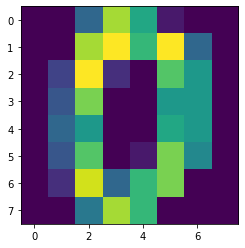

In [6]:
plt.imshow(X[0].reshape(8,8));

In [7]:
y[0]

0

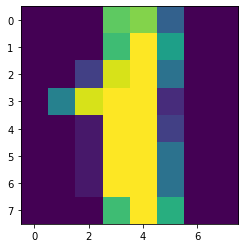

In [8]:
plt.imshow(X[1].reshape(8,8));

In [9]:
y[1]

1

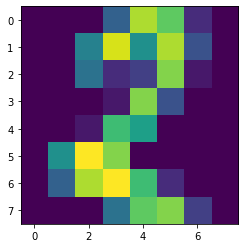

In [10]:
plt.imshow(X[50].reshape(8,8));

In [11]:
y[50]

2

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

---
### We need many `stupid` classifiers which make `errors in different parts` of the feature space.

# 1. Random `features` sampling

In [13]:
predict_proba_models = []

for state in range(5):
    
    model = DecisionTreeClassifier(max_features=4, max_depth=2, random_state=state)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_test)
    predict_proba_models.append(y_pred_proba)
    y_pred = model.predict(X_test)

    print('Test accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Features used for splitting: {}'.format(np.nonzero(model.feature_importances_)))
    print('\n-------\n')
    
predict_proba_models = np.array(predict_proba_models)

Test accuracy: 0.313
Features used for splitting: (array([10, 33, 43]),)

-------

Test accuracy: 0.340
Features used for splitting: (array([21, 50, 54]),)

-------

Test accuracy: 0.337
Features used for splitting: (array([ 2, 25, 44]),)

-------

Test accuracy: 0.301
Features used for splitting: (array([10, 28, 61]),)

-------

Test accuracy: 0.274
Features used for splitting: (array([36, 43, 58]),)

-------



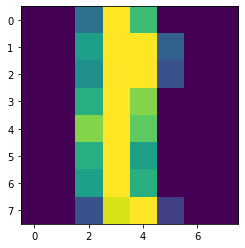

In [14]:
plt.imshow(X_test[0].reshape(8,8))

In [15]:
y_pred_proba[0]

array([0.01623377, 0.08116883, 0.31493506, 0.01623377, 0.03571429,
       0.11038961, 0.03246753, 0.24675325, 0.13636364, 0.00974026])

In [16]:
print(predict_proba_models.shape)

(5, 594, 10)


## Average prediction of 5 Decision Trees on a same `test set`

In [17]:
mean_predict_proba = predict_proba_models.mean(axis=0)
print(mean_predict_proba[:3])

[[0.0654304  0.1205001  0.16681479 0.07728058 0.06610051 0.082567
  0.07777743 0.12617845 0.15818692 0.05916383]
 [0.1379642  0.03741738 0.1759389  0.06424896 0.03936326 0.22055686
  0.07853665 0.09506412 0.09661923 0.05429043]
 [0.26136477 0.03545851 0.16843784 0.02809811 0.01685853 0.12744408
  0.08258417 0.09067697 0.12967333 0.0594037 ]]


In [18]:
mean_predict = np.argmax(mean_predict_proba, axis=1)
print(mean_predict[:3])

[2 5 0]


In [19]:
print(accuracy_score(y_test, mean_predict))

0.6430976430976431


# 2. Random `observations` sample

In [21]:
def bootstrap_indices(random_state, n_samples):
    """Return random indices with repetition (bootstrap)."""
    rs = np.random.RandomState(random_state)
    sample_indices = rs.randint(low=0, high=n_samples, size=n_samples)
    return sample_indices

In [22]:
bootstrap_indices(1, 10)

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9])

In [23]:
X_train.shape

(1203, 64)

In [24]:
predict_proba_models = []

features = [2, 19, 25, 44]

for state in range(5):
   
    ind = bootstrap_indices(state, X_train.shape[0])
    X_train_, y_train_ =  X_train[ind, :][:, features], y_train[ind]
    
    model = DecisionTreeClassifier(max_features=4, max_depth=2, random_state=2)

    model.fit(X_train_, y_train_)
    y_pred_proba = model.predict_proba(X_test[:, features])
    predict_proba_models.append(y_pred_proba)
    
    y_pred = np.argmax(y_pred_proba, axis=1)
    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    print('Features used for splitting: {}'.format(np.nonzero(model.feature_importances_)))
    print('\n-------\n')

predict_proba_models = np.array(predict_proba_models)

Accuracy: 0.242
Features used for splitting: (array([1, 2, 3]),)

-------

Accuracy: 0.279
Features used for splitting: (array([0, 2, 3]),)

-------

Accuracy: 0.311
Features used for splitting: (array([0, 2, 3]),)

-------

Accuracy: 0.295
Features used for splitting: (array([0, 2, 3]),)

-------

Accuracy: 0.279
Features used for splitting: (array([0, 2, 3]),)

-------



In [25]:
mean_predict_proba = predict_proba_models.sum(axis=0) / 5
mean_predict = np.argmax(mean_predict_proba, axis=1)

print(accuracy_score(y_test, mean_predict))

0.3956228956228956


# 3. `Features` and `observations` sampling

In [30]:
# TRAINING

models = []
rs = [1791095845, 2135392491, 946286476, 1857819720, 491263] # list(range(5))

for state in rs:
    
    ind = bootstrap_indices(state, X_train.shape[0])
    X_train_, y_train_ = X_train[ind], y_train[ind]
    
    model = DecisionTreeClassifier(max_features=6, max_depth=2, random_state=state)

    model.fit(X_train_, y_train_)    
    models.append(model)  # Save trained model

# PREDICTION

predict_proba_models = []

for model in models:

    y_pred_proba = model.predict_proba(X_test)
    predict_proba_models.append(y_pred_proba)
    y_pred = np.argmax(y_pred_proba, axis=1)

    print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
    
    
predict_proba_models = np.array(predict_proba_models)

print(predict_proba_models.shape)

mean_predict_proba = predict_proba_models.mean(axis=0)
mean_predict = np.argmax(mean_predict_proba, axis=1)

print('Random Forest Accuracy:', accuracy_score(y_test, mean_predict))

Accuracy: 0.276
Accuracy: 0.320
Accuracy: 0.278
Accuracy: 0.273
Accuracy: 0.311
(5, 594, 10)
Random Forest Accuracy: 0.5909090909090909


# 4. Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
model = RandomForestClassifier(n_estimators=5, max_features=6, max_depth=2, random_state=1) 

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.5909090909090909


In [29]:
rs = []
for m in model.estimators_:
    rs.append(m.random_state)
    
print(rs)

[1791095845, 2135392491, 946286476, 1857819720, 491263]


In [31]:
def rf_train_test_accuracy(param_name, param_grid, **params):
    """Returns train and test perfomance of a RandomForest for
    different values (param_grid) of a hyperparameter (param_name)."""
    
    train_score, test_score = [], []
    clf = RandomForestClassifier(n_estimators=5, max_features=8, max_depth=6, random_state=1, n_jobs=-1)
    if params:
        clf.set_params(**params)
    
    for param_value in tqdm_notebook(param_grid):
        clf.set_params(**{param_name: param_value})
        clf.fit(X_train, y_train)

        train_score.append(accuracy_score(y_train, clf.predict(X_train)))
        test_score.append(accuracy_score(y_test, clf.predict(X_test)))
    return train_score, test_score

## 4.1 Random Forest. Number of trees

In [32]:
train_accuracy, test_accuracy = rf_train_test_accuracy('n_estimators', range(1, 50, 2))

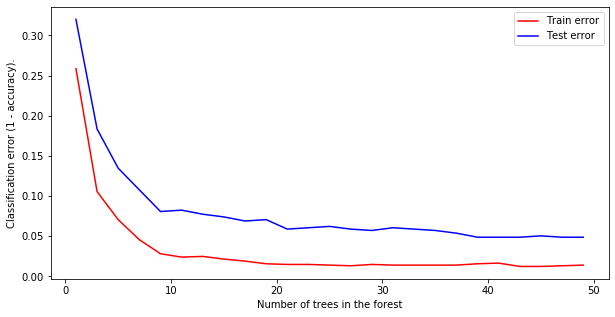

In [33]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,50,2)), 1-np.array(train_accuracy), c='r', label='Train error')
plt.plot(list(range(1,50,2)), 1-np.array(test_accuracy), c='b', label='Test error')
plt.xlabel('Number of trees in the forest')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend();

## 4.2 Random Forest. Tree depth

In [34]:
train_accuracy, test_accuracy = rf_train_test_accuracy('max_depth', range(1, 30))

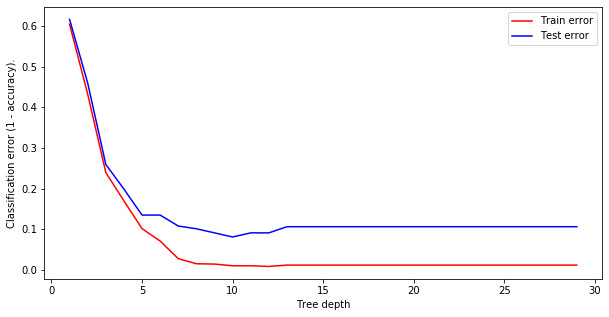

In [35]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1,30)), 1-np.array(train_accuracy), c='r', label='Train error')
plt.plot(list(range(1,30)), 1-np.array(test_accuracy), c='b', label='Test error')
plt.xlabel('Tree depth')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend();

## 4.3 Random Forest. Number of max features

In [36]:
train_accuracy, test_accuracy = rf_train_test_accuracy('max_features', range(1, 64))

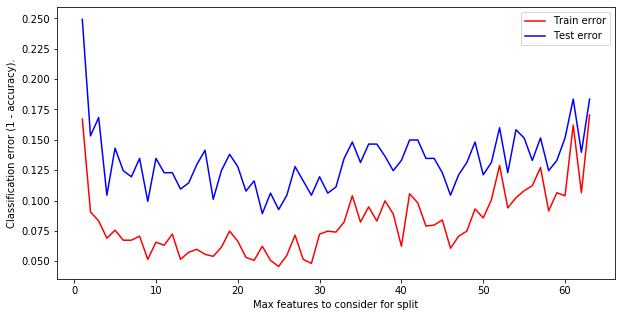

In [37]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1, 64)), 1-np.array(train_accuracy), c='r', label='Train error')
plt.plot(list(range(1, 64)), 1-np.array(test_accuracy), c='b', label='Test error')
plt.xlabel('Max features to consider for split')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend();

In [38]:
params = {
    'n_estimators': 20,
    'max_depth': 10
}
train_accuracy, test_accuracy = rf_train_test_accuracy('max_features', range(1, 64), **params)

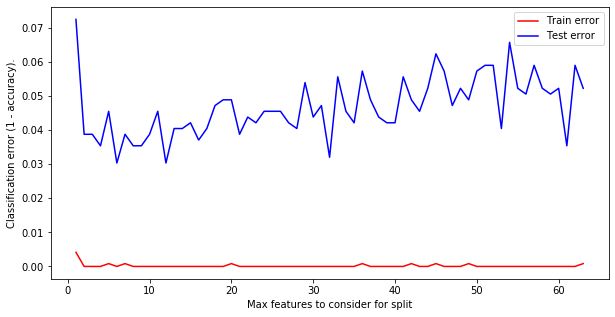

In [39]:
plt.figure(figsize=(10,5))
plt.plot(list(range(1, 64)), 1-np.array(train_accuracy), c='r', label='Train error')
plt.plot(list(range(1, 64)), 1-np.array(test_accuracy), c='b', label='Test error')
plt.xlabel('Max features to consider for split')
plt.ylabel('Classification error (1 - accuracy).')
plt.legend();

In [ ]:
# Typically something between log2(k) and sqrt(k) will work as a max_features